In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras import regularizers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import precision_score, recall_score

In [3]:
import gc

In [4]:
from load_data import LoadDataset

In [5]:
scaler = QuantileTransformer(
       n_quantiles = 10000,
       random_state = 6969,
       output_distribution = "uniform"
)

## Without Sampling

In [5]:
df_train = LoadDataset("./raw/raw_trainset.csv")
df_test = LoadDataset("./raw/raw_testset.csv")

In [6]:
df_train.DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1765609 entries, 0 to 1765608
Data columns (total 69 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int32  
 1   flow_duration                int32  
 2   total_fwd_packets            int32  
 3   total_backward_packets       int32  
 4   total_length_of_fwd_packets  int32  
 5   total_length_of_bwd_packets  int32  
 6   fwd_packet_length_max        int16  
 7   fwd_packet_length_min        int16  
 8   fwd_packet_length_mean       float16
 9   fwd_packet_length_std        float16
 10  bwd_packet_length_max        int16  
 11  bwd_packet_length_min        int16  
 12  bwd_packet_length_mean       float16
 13  bwd_packet_length_std        float16
 14  flow_bytes_s                 float32
 15  flow_packets_s               float32
 16  flow_iat_mean                float32
 17  flow_iat_std                 float32
 18  flow_iat_max                 int32  
 19  

In [7]:
df_train.DataFrame.shape

(1765609, 69)

In [8]:
df_test.DataFrame.shape

(756690, 69)

In [10]:
selected_features = ['destination_port',
            'init_win_bytes_backward',
            'init_win_bytes_forward',
            'bwd_packets_s',
            'fwd_iat_min',
            'min_seg_size_forward',
            'flow_iat_min',
            'flow_duration',
            'total_length_of_fwd_packets',
            'total_backward_packets',
            'bwd_iat_min',
            'bwd_packet_length_std',
            'fwd_iat_total',
            'fwd_packet_length_mean',
            'fwd_packet_length_max',
            'flow_iat_std',
            'fwd_packets_s',
            'down_up_ratio',
            'total_fwd_packets',
            'bwd_packet_length_min',
            'flow_bytes_s',
            'bwd_header_length',
            'packet_length_mean',
            'total_length_of_bwd_packets']

In [11]:
X_train, y_train = df_train.splitTo_X_Y(feature_columns = selected_features, target_columns = ['label'])

In [12]:
print(X_train.shape)
print(y_train.shape)

(1765609, 24)
(1765609, 1)


In [13]:
X_test, y_test = df_test.splitTo_X_Y(feature_columns = selected_features, target_columns = ['label'])

In [14]:
print(X_test.shape)
print(y_test.shape)

(756690, 24)
(756690, 1)


In [15]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
del df_train, df_test
gc.collect()

0

## AutoEncoder

In [19]:
class PrecisionRecallCallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred_prob = self.model.predict(self.X_val)
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        precision = precision_score(self.y_val, y_pred_binary)
        recall = recall_score(self.y_val, y_pred_binary)
        
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.y_val, verbose=0)

        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs["val_precision"] = precision
        logs["val_recall"] = recall

        print(f"val_loss: {val_loss} -- val_accuracy: {val_accuracy} -- val_precision: {precision} -- val_recall: {recall}")

In [20]:
# class PrecisionRecallCallback(Callback):
#     def __init__(self, X_val, y_val):
#         super().__init__()
#         self.X_val = X_val
#         self.y_val = y_val

#     def on_epoch_end(self, epoch, logs=None):
#         y_pred_prob = self.model.predict(self.X_val)
#         y_pred_classes = tf.argmax(y_pred_prob, axis=-1)
        
#         precision_per_class = precision_score(self.y_val, y_pred_classes, average=None)
#         recall_per_class = recall_score(self.y_val, y_pred_classes, average=None)

#         for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
#             logs[f'val_precision_class_{i}'] = precision
#             logs[f'val_recall_class_{i}'] = recall

#             print(f'val_precision_class_{i}: {precision}, val_recall_class_{i}: {recall}')

In [ ]:
checkpoint = ModelCheckpoint(model_save_path, 
                             monitor = 'val_accuracy', verbose = 1, 
                             save_best_only = True, mode = 'min')
    
    early_stop_callback = EarlyStopping(monitor = 'val_accuracy', patience = 5)
    
    input_dim = X_train.shape[1]
    model = Sequential([
        # encode
        Dense(input_dim, activation = 'relu', input_shape = (input_dim, )),
        
        Dense(512, activation = 'relu'),
        Dense(256, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dropout(0.5),
        Dense(64, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dropout(0.2),
        Dense(16, activation = 'relu'),
        # Dropout(0.2),
        
        # classifier
        # Dense(len(y_test['label'].unique()), activation = 'softmax'),
        
        # decode
        # Dense(16, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(256, activation = 'relu'),
        Dense(512, activation = 'relu'), 
        Dropout(0.2),
        
        Dense(input_dim, activation = 'relu')    
    ])
    
    print(model.summary())
    
    model.compile(
        loss = "mae", # mae
        optimizer = Adam(learning_rate = 0.0001),
        metrics = ["accuracy"]
    )
    
    hist = model.fit(X_train, y_train,
                epochs = 200, batch_size = 32, 
                validation_data = (X_test, y_test),
                callbacks = [checkpoint, early_stop_callback])

In [24]:
hist = model.fit(X_train, y_train,
                epochs = 200, batch_size = 32, 
                validation_data = (X_test, y_test),
                callbacks = [checkpoint, early_stop_callback])

Epoch 1/200
55172/55176 [============================>.] - ETA: 0s - loss: 0.4912 - accuracy: 0.8311
Epoch 1: val_accuracy improved from inf to 0.83090, saving model to ./checkpoint\autoencoder_weights.keras
55176/55176 [==============================] - 488s 9ms/step - loss: 0.4912 - accuracy: 0.8311 - val_loss: 0.4931 - val_accuracy: 0.8309
Epoch 2/200
55172/55176 [============================>.] - ETA: 0s - loss: 0.4912 - accuracy: 0.8313
Epoch 2: val_accuracy did not improve from 0.83090
55176/55176 [==============================] - 502s 9ms/step - loss: 0.4912 - accuracy: 0.8313 - val_loss: 0.4931 - val_accuracy: 0.8309
Epoch 3/200
55171/55176 [============================>.] - ETA: 0s - loss: 0.4912 - accuracy: 0.8313
Epoch 3: val_accuracy did not improve from 0.83090
55176/55176 [==============================] - 533s 10ms/step - loss: 0.4912 - accuracy: 0.8313 - val_loss: 0.4931 - val_accuracy: 0.8309
Epoch 4/200
55172/55176 [============================>.] - ETA: 0s - loss: 0

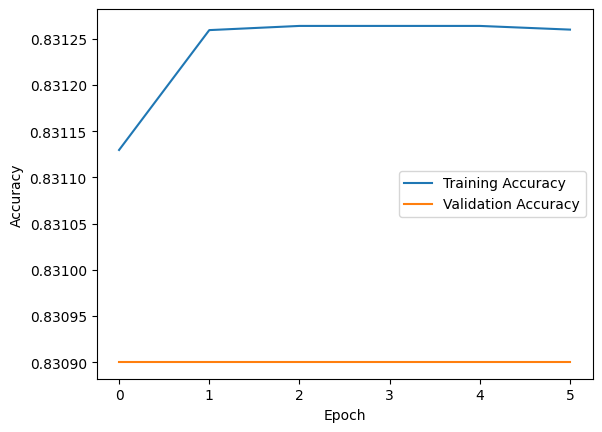

In [25]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label = 'Training Accuracy')
plt.plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
decoded_data = model.predict(X_test)

23647/23647 [==============================] - 61s 3ms/step


In [45]:
# loss = np.mean(np.square(X_test - decoded_data), axis=1) # mse
loss = np.mean(np.abs(X_test - decoded_data), axis=1) # mae

threshold = 0.5
binary_predictions = (loss > threshold).astype(int)

true_labels_indices = np.argmax(y_test, axis=1)

precision = precision_score(true_labels_indices, binary_predictions, average = 'weighted')
recall = recall_score(true_labels_indices, binary_predictions, average = 'weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Precision: 1.0000
Recall: 0.6382


c:\Users\avart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## With sampling

In [7]:
df_train = LoadDataset("./oversampling/NRAS_trainset.csv")
df_test = LoadDataset("./raw/raw_testset.csv")

In [8]:
df_train.shape

(9539966, 70)

In [11]:
df_test.shape

(756690, 69)

In [11]:
X_train, y_train, scaler = df_train.splitTo_X_Y(feature_columns = selected_features, target_columns = ['label'], 
                                                scaler = scaler, scale_type = "fit_transform")

In [12]:
X_test, y_test, scaler = df_test.splitTo_X_Y(feature_columns = selected_features, target_columns = ['label'], 
                                                scaler = scaler, scale_type = "transform")

In [13]:
X_train

array([[0.9844774 , 0.6544154 , 0.43315274, ..., 0.16966696, 0.34843484,
        0.31763175],
       [0.5869087 , 0.7132713 , 0.8349335 , ..., 0.7986299 , 0.5147015 ,
        0.6461105 ],
       [0.96617085, 0.7149215 , 0.45328572, ..., 0.2677768 , 0.        ,
        0.        ],
       ...,
       [0.70822084, 0.48819882, 0.13311331, ..., 0.9531189 , 0.9659966 ,
        0.9905586 ],
       [0.70822084, 0.7033554 , 0.39931998, ..., 0.93100464, 0.98829883,
        0.9220422 ],
       [0.70822084, 0.48819882, 0.13311331, ..., 0.95110595, 0.9659966 ,
        0.99711084]], dtype=float32)

In [14]:
X_test

array([[0.91719941, 0.9730473 , 0.61361136, ..., 0.32768277, 0.        ,
        0.        ],
       [0.1840184 , 0.        , 0.        , ..., 0.59910991, 0.46269627,
        0.54255426],
       [0.1840184 , 0.        , 0.        , ..., 0.59910991, 0.6629663 ,
        0.68741874],
       ...,
       [0.83333333, 0.78582858, 0.76872687, ..., 0.6610161 , 0.35283528,
        0.4689969 ],
       [0.47039704, 0.8960396 , 0.89673967, ..., 0.90274027, 0.71539654,
        0.76109278],
       [0.95780134, 0.        , 0.68826883, ..., 0.        , 0.30888089,
        0.        ]])

In [219]:
checkpoint = ModelCheckpoint("./checkpoint/autoencoder_weights_sampling.keras", 
                             monitor = 'val_accuracy', verbose = 1, 
                             save_best_only = True, mode = 'min')
    
early_stop_callback = EarlyStopping(monitor = 'val_accuracy', patience = 5)

input_dim = X_train.shape[1]
model = Sequential([
    # encode
    Dense(input_dim, activation = 'elu', input_shape = (input_dim, )),
    
    # Dense(1024, activation = 'elu'),
    Dense(512, activation = 'elu'),
    # Dropout(0.3),
    Dense(256, activation = 'elu'),
    # Dropout(0.3),
    Dense(128, activation = 'elu'),
    # Dropout(0.3),
    Dense(64, activation = 'elu'),
    # Dropout(0.3),
    Dense(32, activation = 'elu'),
    # Dropout(0.5),
    # Dense(16, activation = 'elu'),
    # Dropout(0.2),
    
    # classifier
    Dense(len(y_test['label'].unique()), activation = 'elu'),
    # Dense(16, activation = 'elu'),
    
    # decode
    Dense(32, activation = 'elu'),
    Dense(64, activation = 'elu'),
    Dense(128, activation = 'elu'),
    Dense(256, activation = 'elu'),
    # Dropout(0.3),
    Dense(512, activation = 'elu'), 
    # Dense(1024, activation = 'elu'),
    # Dropout(0.2),
    
    Dense(input_dim, activation = 'elu')    
])

model.compile(
    loss = "sparse_categorical_crossentropy", # , mae
    optimizer = Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)



In [220]:
hist = model.fit(X_train, y_train,
            epochs = 200, batch_size = 32, 
            validation_data = (X_test, y_test),
            callbacks = [checkpoint, early_stop_callback])

Epoch 1/200
298122/298124 [============================>.] - ETA: 0s - loss: 3.1847 - accuracy: 0.1000
Epoch 1: val_accuracy improved from inf to 0.00001, saving model to ./checkpoint\autoencoder_weights_sampling.keras
298124/298124 [==============================] - 5481s 18ms/step - loss: 3.1847 - accuracy: 0.1000 - val_loss: 3.1789 - val_accuracy: 1.4537e-05
Epoch 2/200
298123/298124 [============================>.] - ETA: 0s - loss: 3.1842 - accuracy: 0.1000
Epoch 2: val_accuracy did not improve from 0.00001
298124/298124 [==============================] - 2177s 7ms/step - loss: 3.1842 - accuracy: 0.1000 - val_loss: 3.1789 - val_accuracy: 1.4537e-05
Epoch 3/200
175479/298124 [================>.............] - ETA: 17:22 - loss: 3.1819 - accuracy: 0.0999

KeyboardInterrupt: 

In [218]:
%reset_selective -f model
gc.collect()

5770